# Openclassrooms PJ4 : transats dataset : modelisation notebook

In [73]:
%matplotlib inline

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import qgrid

import glob

from pandas.plotting import scatter_matrix

SAMPLED_DATA = False  # If True : data is sampled (1000 instances only) for faster testing purposes

DATA_PATH = os.path.join("datasets", "transats")
DATA_PATH = os.path.join(DATA_PATH, "out")

DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "transats_metadata_transformed.csv")

plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :
RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = True # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX

#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = False # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


In [2]:
def qgrid_show(df):
    display(qgrid.show_grid(df, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 170}))

In [3]:
def print_column_information(df, column_name):
    column_type = df.dtypes[column_name]
    print(f'Column {column_name}, type {column_type}\n')
    print('--------------------------')

    print(df[[column_name]].groupby(column_name).size().sort_values(ascending=False))
    print(df[column_name].unique())    
    print('\n')


In [4]:
def display_percent_complete(df):
    not_na = 100 - (df.isnull().sum() * 100 / len(df))
    not_na_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_complete': not_na}).sort_values(by='percent_complete', ascending=False)
    display(not_na_df)

In [5]:
def identify_features(df, all_features):
    quantitative_features = []
    qualitative_features = []
    features_todrop = []

    for feature_name in all_features:
        if (df[feature_name].dtype == 'object'):
            qualitative_features.append(feature_name)

        else:
            quantitative_features.append(feature_name)

    print(f'Quantitative features : {quantitative_features} \n')
    print(f'Qualitative features : {qualitative_features} \n')  
    
    return quantitative_features, qualitative_features

In [6]:
def save_or_load_search_params(grid_search, save_file_suffix):
    if (SAVE_GRID_RESULTS == True):
        #df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
        #df_grid_search_results.to_csv(GRIDSEARCH_CSV_FILE)

        df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["std_test_score"], columns=["std_test_score"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_fit_time"], columns=["mean_fit_time"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_score_time"], columns=["mean_score_time"])],axis=1)
        df_grid_search_results.to_csv(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.csv')

        with open(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.pickle', 'wb') as f:
            pickle.dump(grid_search, f, pickle.HIGHEST_PROTOCOL)
            
        return(grid_search, df_grid_search_results)

    if (LOAD_GRID_RESULTS == True):
        if ((SAVE_GRID_RESULTS == True) or (RECOMPUTE_GRIDSEARCH == True)):
            print('Error : if want to load grid results, you should not have saved them or recomputed them before, or you will loose all your training data')

        else:
            with open(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.pickle', 'rb') as f:
                grid_search = pickle.load(f)

            df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["std_test_score"], columns=["std_test_score"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_fit_time"], columns=["mean_fit_time"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_score_time"], columns=["mean_score_time"])],axis=1)
            
            return(grid_search, df_grid_search_results)

In [67]:
def evaluate_model(model, X_test, Y_test):
    Y_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_predict)
    rmse = np.sqrt(mse)
    print(f'RMSE : {rmse}')
    

# Data load

In [7]:
# hhmm timed features formatted
feats_hhmm = ['CRS_DEP_TIME',  'CRS_ARR_TIME']

df = pd.read_csv(DATA_PATH_FILE_INPUT, sep=',', header=0, encoding='utf-8', low_memory=False, parse_dates=feats_hhmm)

In [8]:
df.shape

(5547828, 14)

In [9]:
display_percent_complete(df)

,column_name,percent_complete
ORIGIN,ORIGIN,100.0
CRS_DEP_TIME,CRS_DEP_TIME,100.0
MONTH,MONTH,100.0
DAY_OF_MONTH,DAY_OF_MONTH,100.0
DAY_OF_WEEK,DAY_OF_WEEK,100.0
UNIQUE_CARRIER,UNIQUE_CARRIER,100.0
DEST,DEST,100.0
CRS_ARR_TIME,CRS_ARR_TIME,100.0
DISTANCE,DISTANCE,100.0
CRS_ELAPSED_TIME,CRS_ELAPSED_TIME,100.0


In [10]:
'''
for column_name in df.columns:
    print_column_information(df, column_name)
    
'''

'\nfor column_name in df.columns:\n    print_column_information(df, column_name)\n    \n'

# Identification of features

In [11]:
# Below are feature from dataset that we decided to keep: 
all_features = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME','ARR_DELAY','DEP_DELAY', 'TAXI_OUT', 'TAIL_NUM']

model1_features = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME']
model1_label = 'ARR_DELAY'

quantitative_features = []
qualitative_features = []
features_todrop = []

for feature_name in all_features:
    if (df[feature_name].dtype == 'object'):
        qualitative_features.append(feature_name)
        
    else:
        quantitative_features.append(feature_name)

print(f'Quantitative features : {quantitative_features} \n')
print(f'Qualitative features : {qualitative_features} \n')        
        

#Commented out : no drop of features
#for df_column in df.columns:
#    if df_column not in all_features:
#        features_todrop.append(df_column)
#        
#print(f'Features to drop : {features_todrop} \n')


Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



# Split train set, test set

In [12]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train = df_train.copy()
df_test = df_test.copy()

In [13]:
if (SAMPLED_DATA == True):
    df_train = df_train.sample(1200000).copy(deep=True)
    df = df.loc[df_train.index]

In [14]:
df_train

,ORIGIN,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,TAIL_NUM
3352894,HPN,1537,3,29,2,B6,PBI,1829,1056.0,172.0,10.0,1.0,9.0,N339JB
1268114,ORD,1220,6,22,3,UA,IAH,1509,925.0,169.0,175.0,184.0,23.0,N79402
2193866,SAN,1335,12,26,1,UA,DEN,1703,853.0,148.0,-12.0,5.0,20.0,N17244
3874513,HDN,1620,1,22,5,OO,LAX,1738,763.0,138.0,-16.0,-10.0,9.0,N785SK
2213800,ORD,0730,12,12,1,UA,BOS,1044,867.0,134.0,53.0,52.0,31.0,N801UA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570006,DEN,1355,5,7,6,WN,LAX,1520,862.0,145.0,13.0,5.0,16.0,N455WN
2234489,SFO,1725,12,13,2,VX,DAL,2250,1476.0,205.0,-12.0,-5.0,11.0,N625VA
4926484,IAH,1015,11,11,5,UA,SJU,1630,2007.0,255.0,-5.0,1.0,20.0,N67812
4304572,IAH,1950,10,4,2,UA,DFW,2115,224.0,85.0,-15.0,-2.0,18.0,N834UA


In [15]:
#df = df.loc[df_train.index]

# Features encoding

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn import decomposition
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import statistics

from scipy import sparse

'''
Cette fonction fait un 1 hot encoding des features qui sont des catégories
Old function not used anymore
'''
    
def add_categorical_features_1hot(df, categorical_features_totransform):
    #df.drop(labels=categorical_features_totransform, axis=1, inplace=True)
    
    
    #df_encoded = pd.get_dummies(df, columns=categorical_features_totransform, sparse=True)
    
    for feature_totransform in categorical_features_totransform:
        print(f'Adding 1hot Feature : {feature_totransform}')
        
        print('First')
        df_transformed = df[feature_totransform].str.get_dummies().add_prefix(feature_totransform +'_')   
        
        #df_new = pd.get_dummies(df, columns=['ORIGIN'])
        
        
        
        
        #df.drop(labels=feature_totransform, axis=1, inplace=True)
        print('Second')
        del df[feature_totransform]
        
        print('Third')
        df = pd.concat([df, df_transformed], axis=1)
        
    return(df)


class HHMM_to_Minutes(BaseEstimator, TransformerMixin):
    def __init__(self, features_toconvert = ['CRS_DEP_TIME', 'CRS_ARR_TIME']):
        self.features_toconvert = features_toconvert
        return None
    
    def fit(self, df):      
        return self
    
    def transform(self, df):       
        for feature_toconvert in self.features_toconvert:
            print(f'Converting feature {feature_toconvert}\n')
            #print('1\n')
            df_concat = pd.concat([df[feature_toconvert].str.slice(start=0,stop=2, step=1),df[feature_toconvert].str.slice(start=2,stop=4, step=1)], axis=1).astype(int).copy(deep=True)
                    
            #print('2\n')
            df[feature_toconvert] = (df_concat.iloc[:, [0]] * 60 + df_concat.iloc[:, [1]])[feature_toconvert]
            
            #print('3\n')
        
        return(df)

    
'''
class CategoricalFeatures1HotEncoder_old(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
        self.categorical_features_totransform = categorical_features_totransform
    
    def fit(self, df, labels=None):      
        return self
    
    def transform(self, df):
        # /!\ Array will not have the same shape if we fit an ensemble of samples that have less values than total dataset
        df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=True)  # Sparse allows to gain memory. But then, standardscale must be with_mean=False
        #df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=False)
        print('type of df : ' + str(type(df_encoded)))
        return(df_encoded)
'''

class CategoricalFeatures1HotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
        self.categorical_features_totransform = categorical_features_totransform
        self.fitted = False
        self.all_feature_values = {}
        #self.df_encoded = None
    
    def fit(self, df, labels=None):      
        print('Fit data')
        for feature_name in self.categorical_features_totransform:
            self.all_feature_values[feature_name] = feature_name + '_' + df[feature_name].unique()
        
        self.fitted = True
        
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            self.fit(df)
        
        print('Transform data')
        print('1hot encode categorical features...')
        df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=True)  # Sparse allows to gain memory. But then, standardscale must be with_mean=False
        #df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=False)
        
        # Get category values that were in fitted data, but that are not in data to transform 
        for feature_name, feature_values in self.all_feature_values.items():
            diff_columns = list(set(feature_values) - set(df_encoded.columns.tolist()))
            print(f'Column values that were in fitted data but not in current data: {diff_columns}')
        
            if (len(diff_columns) > 0):
                print('Adding those column with 0 values to the DataFrme...')
                # Create columns with 0 for the above categories, in order to preserve same matrix shape between train et test set
                zeros_dict = dict.fromkeys(diff_columns, 0)
                df_encoded.assign(**zeros_dict)
        
        print('type of df : ' + str(type(df_encoded)))
        return(df_encoded)
    
    
class FeaturesSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features_toselect = None):  # If None : every column is kept, nothing is done
        self.features_toselect = features_toselect
    
    def fit(self, df, labels=None):      
        return self
    
    def transform(self, df):       
        if (self.features_toselect != None):
            filter_cols = [col for col in df if (col.startswith(tuple(self.features_toselect)))]
            return(df[filter_cols])    

        else:
            return(df)

'''
In order have less features globally: we Keep only features_tofilter that represent percent_tokeep% of total values
Features which values represent less than percent_tokeep% will be set "OTHERS" value instead of their real value
'''

class Filter_High_Percentile(BaseEstimator, TransformerMixin):
    def __init__(self, features_tofilter = ['ORIGIN', 'DEST'], percent_tokeep = 80):
        self.features_tofilter = features_tofilter
        self.percent_tokeep = percent_tokeep
        self.high_percentile = None
        self.low_percentile = None
    
    def fit(self, df, labels=None): 
        print('Fit high percentile filter...')
        for feature_tofilter in self.features_tofilter:
            # Get feature_tofilter values that represent 80% of data
            self.high_percentile = ((((df[[feature_tofilter]].groupby(feature_tofilter).size() / len(df)).sort_values(ascending=False)) * 100).cumsum() < self.percent_tokeep).where(lambda x : x == True).dropna().index.values.tolist()
            self.low_percentile = ((((df[[feature_tofilter]].groupby(feature_tofilter).size() / len(df)).sort_values(ascending=False)) * 100).cumsum() >= self.percent_tokeep).where(lambda x : x == True).dropna().index.values.tolist()

            total = len(df[feature_tofilter].unique())
            high_percentile_sum = len(self.high_percentile)
            low_percentile_sum = len(self.low_percentile)
            high_low_sum = high_percentile_sum + low_percentile_sum

            print(f'Total number of {feature_tofilter} values : {total}')
            print(f'Number of {feature_tofilter} high percentile (> {self.percent_tokeep}%) values : {high_percentile_sum}')
            print(f'Number of {feature_tofilter} low percentile values : {low_percentile_sum}')
            print(f'Sum of high percentile + low percentile values : {high_low_sum}')
        
        return self
    
    def transform(self, df):       
        if (self.features_tofilter != None):
            print('Apply high percentile filter...')
            
            for feature_tofilter in self.features_tofilter:
                df.loc[df[feature_tofilter].isin(self.low_percentile), feature_tofilter] = 'OTHERS'   
            
            return(df)    

        else:
            return(df)
        

    
class DenseToSparseConverter(BaseEstimator, TransformerMixin):
    def __init__(self):  # If None : every column is kept, nothing is done
        return None
    
    def fit(self, matrix, labels=None):      
        return self
    
    def transform(self, matrix):   
        return(sparse.csr_matrix(matrix))

        
        
'''
conversion_pipeline = Pipeline([
    ('data_converter', HHMM_to_Minutes()),
    #('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])
'''

preparation_pipeline = Pipeline([
    ('filter_highpercentile', Filter_High_Percentile()),
    ('data_converter', HHMM_to_Minutes()),
    ('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])


# If matrix is sparse, with_mean=False must be passed to StandardScaler
prediction_pipeline = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME'])),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), ['CRS_DEP_TIME','MONTH','DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_ARR_TIME', 'DISTANCE', 'CRS_ELAPSED_TIME'])
    ], remainder='passthrough', sparse_threshold=1)),
    
    ('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])
#copy=False passed to StandardScaler() allows to gain memory

'''
# Old code that used scikit learn OneHotEncoder (which does not keep DataFrame type) instead of Pandas
preparation_pipeline2 = Pipeline([
    ('data_converter', HHMM_to_Minutes()),
    ('multiple_encoder', ColumnTransformer([
        ('categoricalfeatures_1hotencoder', OneHotEncoder(), ['ORIGIN', 'UNIQUE_CARRIER', 'DEST'])
    ], remainder='passthrough')),
    #('standardscaler', preprocessing.StandardScaler()),
])
'''

'''
ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'])
    ], remainder='passthrough')
'''

"\nColumnTransformer([\n        ('standardscaler_specific', StandardScaler(), ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'])\n    ], remainder='passthrough')\n"

In [17]:
df_train_transformed = preparation_pipeline.fit_transform(df_train)

Fit high percentile filter...
Total number of ORIGIN values : 308
Number of ORIGIN high percentile (> 80%) values : 45
Number of ORIGIN low percentile values : 263
Sum of high percentile + low percentile values : 308
Total number of DEST values : 308
Number of DEST high percentile (> 80%) values : 45
Number of DEST low percentile values : 263
Sum of high percentile + low percentile values : 308
Apply high percentile filter...
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>


In [18]:
df_train_transformed.shape

(4993045, 115)

In [19]:
df_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993045 entries, 3352894 to 1692743
Columns: 115 entries, CRS_DEP_TIME to DEST_TPA
dtypes: Sparse[uint8, 0](104), float64(5), int64(5), object(1)
memory usage: 528.6+ MB


In [20]:
df_train_transformed = prediction_pipeline.fit_transform(df_train_transformed)

In [21]:
df_train_transformed.shape

(4993045, 111)

In [22]:
from scipy import sparse
sparse.issparse(df_train_transformed)

True

In [23]:
#df_train_transformed.info()

In [24]:
pd.set_option('display.max_columns', 400)

In [25]:
quantitative_features, qualitative_features = identify_features(df, all_features)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



# Test set encoding

In [26]:
df_test_transformed = preparation_pipeline.transform(df_test)
df_test_transformed = prediction_pipeline.transform(df_test_transformed)
df_test_transformed.shape

Apply high percentile filter...
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>


(554783, 111)

# Linear regression

In [27]:
df_train_transformed.shape

(4993045, 111)

In [28]:
df_train[model1_label].shape

(4993045,)

In [29]:
from sklearn.linear_model import LinearRegression

if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression()
    lin_reg.fit(df_train_transformed, df_train[model1_label])

In [30]:
from sklearn.metrics import mean_squared_error

if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = lin_reg.predict(df_test_transformed)
    lin_mse = mean_squared_error(df_test[model1_label], df_test_predictions)
    lin_rmse = np.sqrt(lin_mse)
    lin_rmse



=> 42.17  (42.16679389006135)

In [31]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral')

In [32]:
from sklearn.model_selection import cross_validate

#scores = cross_validate(lin_reg, df_train_transformed, df_train[model1_label], scoring='neg_root_mean_squared_error', cv=5)

In [33]:
#scores['test_score'].mean()

# ElasticNET regression

In [34]:
from sklearn.model_selection import ShuffleSplit


shuffled_split_train = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)


In [35]:
from sklearn.linear_model import ElasticNet

In [36]:
from sklearn.model_selection import GridSearchCV

eNet = ElasticNet()

grid_search = GridSearchCV(eNet, param_grid = {"max_iter": [1, 5, 10],
                      "alpha": [10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.4)},cv=shuffled_split_train, scoring='neg_mean_squared_error', error_score=np.nan, verbose=2)

In [37]:
'''
from sklearn.model_selection import GridSearchCV

eNet = ElasticNet()

grid_search = GridSearchCV(eNet, param_grid = {"max_iter": [1, 5, 10],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)},cv=shuffled_split_train, scoring='neg_mean_squared_error', error_score=np.nan, verbose=2)
'''

'\nfrom sklearn.model_selection import GridSearchCV\n\neNet = ElasticNet()\n\ngrid_search = GridSearchCV(eNet, param_grid = {"max_iter": [1, 5, 10],\n                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],\n                      "l1_ratio": np.arange(0.0, 1.0, 0.1)},cv=shuffled_split_train, scoring=\'neg_mean_squared_error\', error_score=np.nan, verbose=2)\n'

In [38]:
if (RECOMPUTE_GRIDSEARCH == True):
    grid_search.fit(df_train_transformed, df_train[model1_label])

In [39]:
grid_search, df_grid_search_results = save_or_load_search_params(grid_search, 'eNet_20200319')

In [40]:
df_grid_search_results.sort_values(by='mean_test_score', ascending=False)

,alpha,l1_ratio,max_iter,mean_test_score,std_test_score,mean_fit_time,mean_score_time
0,10,0.0,1,-1741.474494,11.553554,8.451748,0.021589
2,10,0.0,10,-1741.606988,11.553293,19.897743,0.017433
1,10,0.0,5,-1741.606988,11.553293,11.345686,0.018125
9,100,0.0,1,-1746.266246,11.555358,3.253050,0.018168
10,100,0.0,5,-1746.268263,11.555355,10.535562,0.017086
11,100,0.0,10,-1746.268263,11.555355,19.410727,0.016518
4,10,0.4,5,-1746.670284,11.555964,3.243109,0.018928
5,10,0.4,10,-1746.670284,11.555964,3.316887,0.018247
3,10,0.4,1,-1746.670284,11.555964,2.742426,0.017680
6,10,0.8,1,-1746.913947,11.555634,2.613709,0.016329


In [41]:
np.sqrt(1741.47)

41.73092378560532

=> 41.73092378560532

In [42]:
grid_search.best_estimator_

ElasticNet(alpha=10, copy_X=True, fit_intercept=True, l1_ratio=0.0, max_iter=1,
           normalize=False, positive=False, precompute=False, random_state=None,
           selection='cyclic', tol=0.0001, warm_start=False)

In [43]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    if (RECOMPUTE_GRIDSEARCH == True):
        df_test_predictions = grid_search.best_estimator_.predict(df_test_transformed)
        mse = mean_squared_error(df_test[model1_label], df_test_predictions)
        rmse = np.sqrt(mse)
        rmse


In [44]:
from sklearn import metrics 
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

## Naive approach

### Random value between min and max

In [45]:
y_pred_random = np.random.randint(df['ARR_DELAY'].min(), df['ARR_DELAY'].max(), df_test['ARR_DELAY'].shape)
naive_mse = mean_squared_error(df_test[model1_label], y_pred_random)
naive_rmse = np.sqrt(naive_mse)
naive_rmse

1193.8307281262264

### Always mean naive approach

In [46]:
from sklearn import dummy

dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(df_train_transformed, df_train[model1_label])

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(df_test_transformed)

# Evaluate
print("RMSE : {:.2f}".format(np.sqrt(mean_squared_error(df_test[model1_label], y_pred_dum)) ))


RMSE : 42.63


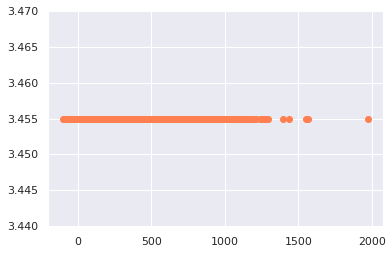

In [47]:
plt.scatter(df_test[model1_label], y_pred_dum, color='coral')

In [48]:
df_test[model1_label]

3746453    62.0
1300593   -22.0
4707023   -11.0
1752505   -38.0
2152691    -1.0
           ... 
2882585    -8.0
298857     -7.0
4799315     5.0
5392696     7.0
236730     -4.0
Name: ARR_DELAY, Length: 554783, dtype: float64

In [49]:
y_pred_dum

array([3.45500812, 3.45500812, 3.45500812, ..., 3.45500812, 3.45500812,
       3.45500812])

In [50]:
df['ARR_DELAY'].abs().mean()

20.15843930273253

=> With all samples and 70% most represented features, without StandardScale :  on test set : lin_rmse = 42.17  
=> With all samples and 80% most represented features, without StandardScale :  on test set : lin_rmse = 42.16  
=> With all samples and 80% most represented features, with StandardScale :  on test set : lin_rmse = 42.16

# Random forest

In [51]:
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])

In [52]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    mse = mean_squared_error(df_test[model1_label], df_test_predictions)
    rmse = np.sqrt(mse)
    rmse


=> 42.373691516139964

# SVM

In [53]:
'''
from sklearn.svm import SVR

svm_reg = SVR(kernel="rbf", verbose=True)
svm_reg.fit(df_train_transformed, df_train[model1_label])
'''

'\nfrom sklearn.svm import SVR\n\nsvm_reg = SVR(kernel="rbf", verbose=True)\nsvm_reg.fit(df_train_transformed, df_train[model1_label])\n'

In [54]:
from sklearn.svm import LinearSVR

if (EXECUTE_INTERMEDIATE_MODELS == True):
    svm_reg = LinearSVR(random_state=42, tol=1e-5, verbose=True)
    svm_reg.fit(df_train_transformed, df_train[model1_label])

[LibLinear]

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=0, tol=1e-05, verbose=True)

In [68]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(svm_reg, df_test_transformed, df_test[model1_label])

RMSE : 43.45607643335432


=> RMSE : 43.45607643335432

In [71]:
grid_search_SVR = GridSearchCV(svm_reg, param_grid = {"epsilon": [0, 0.5],
                      "C": [1, 5, 10, 100, 1000],
                      "loss": ['epsilon_insensitive', 'squared_epsilon_insensitive'],},cv=shuffled_split_train, scoring='neg_mean_squared_error', error_score=np.nan, verbose=2)

In [ ]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    if (RECOMPUTE_GRIDSEARCH == True):
        grid_search_SVR.fit(df_train_transformed, df_train[model1_label])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=1, epsilon=0, loss=epsilon_insensitive ........................
[LibLinear][CV] ......... C=1, epsilon=0, loss=epsilon_insensitive, total=  44.4s
[CV] C=1, epsilon=0, loss=epsilon_insensitive ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.4s remaining:    0.0s


[LibLinear][CV] ......... C=1, epsilon=0, loss=epsilon_insensitive, total=  45.2s
[CV] C=1, epsilon=0, loss=epsilon_insensitive ........................
[LibLinear][CV] ......... C=1, epsilon=0, loss=epsilon_insensitive, total=  45.1s
[CV] C=1, epsilon=0, loss=epsilon_insensitive ........................
[LibLinear][CV] ......... C=1, epsilon=0, loss=epsilon_insensitive, total=  42.1s
[CV] C=1, epsilon=0, loss=epsilon_insensitive ........................
[LibLinear][CV] ......... C=1, epsilon=0, loss=epsilon_insensitive, total=  41.5s
[CV] C=1, epsilon=0, loss=squared_epsilon_insensitive ................
[LibLinear]

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . C=1, epsilon=0, loss=squared_epsilon_insensitive, total=18.0min
[CV] C=1, epsilon=0, loss=squared_epsilon_insensitive ................
[LibLinear]

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . C=1, epsilon=0, loss=squared_epsilon_insensitive, total=18.7min
[CV] C=1, epsilon=0, loss=squared_epsilon_insensitive ................
[LibLinear]

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . C=1, epsilon=0, loss=squared_epsilon_insensitive, total=19.2min
[CV] C=1, epsilon=0, loss=squared_epsilon_insensitive ................
[LibLinear]

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . C=1, epsilon=0, loss=squared_epsilon_insensitive, total=19.2min
[CV] C=1, epsilon=0, loss=squared_epsilon_insensitive ................
[LibLinear]

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . C=1, epsilon=0, loss=squared_epsilon_insensitive, total=18.4min
[CV] C=1, epsilon=0.5, loss=epsilon_insensitive ......................
[LibLinear][CV] ....... C=1, epsilon=0.5, loss=epsilon_insensitive, total=  42.3s
[CV] C=1, epsilon=0.5, loss=epsilon_insensitive ......................
[LibLinear][CV] ....... C=1, epsilon=0.5, loss=epsilon_insensitive, total=  43.1s
[CV] C=1, epsilon=0.5, loss=epsilon_insensitive ......................
[LibLinear][CV] ....... C=1, epsilon=0.5, loss=epsilon_insensitive, total=  42.4s
[CV] C=1, epsilon=0.5, loss=epsilon_insensitive ......................
[LibLinear][CV] ....... C=1, epsilon=0.5, loss=epsilon_insensitive, total=  43.1s
[CV] C=1, epsilon=0.5, loss=epsilon_insensitive ......................
[LibLinear][CV] ....... C=1, epsilon=0.5, loss=epsilon_insensitive, total=  43.7s
[CV] C=1, epsilon=0.5, loss=squared_epsilon_insensitive ..............
[LibLinear]

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1, epsilon=0.5, loss=squared_epsilon_insensitive, total=18.3min
[CV] C=1, epsilon=0.5, loss=squared_epsilon_insensitive ..............
[LibLinear]

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1, epsilon=0.5, loss=squared_epsilon_insensitive, total=18.4min
[CV] C=1, epsilon=0.5, loss=squared_epsilon_insensitive ..............
[LibLinear]

In [ ]:
grid_search_SVR, df_grid_search_results = save_or_load_search_params(grid_search_SVR, 'LinearSVR_20200319')

In [ ]:
df_grid_search_results.sort_values(by='mean_test_score', ascending=False)

In [ ]:
evaluate_model(grid_search_SVR, df_test_transformed, df_test[model1_label])
grid_search_SVR.best_estimator_

# Polynomial features + linear regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_reg = Pipeline([('poly', PolynomialFeatures(degree=3)),
                          ('linear', LinearRegression(fit_intercept=False))])

polynomial_reg.fit(df_train_transformed, df_train[model1_label])

In [ ]:
evaluate_model(polynomial_reg, df_test_transformed, df_test[model1_label])

# Annex : unused code

In [55]:
'''from sklearn import linear_model

regressor = linear_model.SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
regressor.fit(df_transformed, df_train[model1_label])
'''

'from sklearn import linear_model\n\nregressor = linear_model.SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)\nregressor.fit(df_transformed, df_train[model1_label])\n'

In [56]:
'''
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(df_train_transformed, df_train[model1_label])
'''

'\nfrom sklearn.svm import SVR\n\nsvm_reg = SVR(kernel="linear")\nsvm_reg.fit(df_train_transformed, df_train[model1_label])\n'

In [57]:
'''
df_test_predictions = svm_reg.predict(df_test_transformed)
svm_mse = mean_squared_error(df_test[model1_label], df_test_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse
'''

'\ndf_test_predictions = svm_reg.predict(df_test_transformed)\nsvm_mse = mean_squared_error(df_test[model1_label], df_test_predictions)\nsvm_rmse = np.sqrt(svm_mse)\nsvm_rmse\n'

In [58]:
'''
from sklearn.model_selection import StratifiedShuffleSplit

stratified_split_train = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
'''

'\nfrom sklearn.model_selection import StratifiedShuffleSplit\n\nstratified_split_train = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)\n'